**Import all the librairies and functions**

In [16]:
import os
import sys
import importlib
import json
from dataclasses import dataclass, field, fields
from itertools import compress
import csv
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, filtfilt, freqz
import openpyxl
from openpyxl import Workbook, load_workbook
import xlrd
#MNE
import mne
from mne.time_frequency import tfr_morlet
from importlib import reload 
from os.path import join, dirname, realpath, exists

#load poly5reader
# define current working directory (the one that contains this notebook): this is the project_path
os.chdir('c:\\Users\\Juliette\\Research\\Projects\\Synchronization project\\Code\\Synchronization')
project_path = os.getcwd()

# change temporarily the working directory to go fetch the poly5 reader: this is the code_path
os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.join(os.getcwd(), 'tmsi-python-interface-main'))
code_path = os.getcwd()

print (f'working dir for analysis:{project_path}')
print (f'working dir to go fetch Poly5 reader:{code_path}')

#fetch the poly5 reader
from TMSiFileFormats.file_readers import Poly5Reader

# set the working directory back to the project_path
os.chdir(project_path)

# load pyPerceive functions
os.chdir('c:\\Users\\Juliette\\Research\\Projects\\Synchronization project\\Code\\Synchronization')
project_path = os.getcwd()
os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.join(os.getcwd(), 'PyPerceive'))
os.chdir(os.path.join(os.getcwd(), 'code'))
code_path = os.getcwd()
print (f'working dir for analysis:{project_path}')
print (f'working dir to go fetch PyPerceive functions:{code_path}')

from PerceiveImport.classes import (
    main_class, modality_class, metadata_class,
    session_class, condition_class, task_class,
    contact_class, run_class
)
import PerceiveImport.methods.load_rawfile as load_rawfile
import PerceiveImport.methods.find_folders as find_folders
import PerceiveImport.methods.metadata_helpers as metaHelpers

#reset the proper working directory for the analysis
os.chdir(project_path)

working dir for analysis:c:\Users\Juliette\Research\Projects\Synchronization project\Code\Synchronization
working dir to go fetch Poly5 reader:c:\Users\Juliette\Research\Projects\Synchronization project\Code\tmsi-python-interface-main
working dir for analysis:c:\Users\Juliette\Research\Projects\Synchronization project\Code\Synchronization
working dir to go fetch PyPerceive functions:c:\Users\Juliette\Research\Projects\Synchronization project\Code\PyPerceive\code


**Open LFP data**

if PyPerceive:

In [ ]:
# define an example instance and fill in the values of the dataclass PerceiveData 
# choose the values you are interested in analyzing further

sub061 = main_class.PerceiveData(
    sub = "061", 
    incl_modalities=['survey', 'streaming'],
    incl_session = ['postop', 'fu12m', 'fu18m'],
    incl_condition =['m0s0', ],
    incl_task = ["rest"],
    incl_contact = ["RingL", "SegmInterR", "SegmIntraR"],
    import_json=False,
    warn_for_metaNaNs=True,
    # use_bids=True,  # TODO: add to functionality
)

#store the MNE object in the variable
sub061_data = sub061.streaming.postop.m0s0.rest.run1.data
#look at the MNE object
sub061_data

without pyPerceive:

Example with sub-029 18MFU M0S0 Rest:

In [17]:
datapath = 'C:\\Users\\Juliette\\OneDrive\\Bureau\\Recordings\\PERCEPT recordings\\sub-029\\18MFU\\MedOFF\\sub-20210924PStn\\ses-2023020808345883\\ieeg'
filename = 'sub-20210924PStn_ses-2023020808345883_run-BrainSense20230208091500.mat'
data = mne.io.read_raw_fieldtrip(        
	os.path.join(datapath, filename),        
	info={}, # add info here        
	data_name='data',  # name of heading dict/ variable of original MATLAB object    
)
data.ch_names
n_chan = len(data.ch_names)
data.n_times #number of samples
data.times #timepoints set to zero
data._data # channel trials
data.info['sfreq'] # sampling frequency
time_duration = (data.n_times/data.info['sfreq']).astype(float)
time_duration_ms=time_duration*1000
print(     
	f'The data object has:\n\t{data.n_times} time samples,'      
	f'\n\tand a sample frequency of {data.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{data.ch_names}.')


Creating RawArray with float64 data, n_channels=6, n_times=43063
    Range : 0 ... 43062 =      0.000 ...   172.248 secs
Ready.
The data object has:
	43063 time samples,
	and a sample frequency of 250.0 Hz
	with a recording duration of 172.252 seconds.
	6 channels were labeled as 
['LFP_Stn_L_13', 'LFP_Stn_R_03', 'LFP_Stn_L_13_PEAK17Hz_THR20-30_AVG3000ms', 'LFP_Stn_R_03_PEAK16Hz_THR20-30_AVG3000ms', 'STIM_L_125Hz_60us', 'STIM_R_125Hz_60us'].


c:\Users\Juliette\anaconda3\envs\mne\lib\site-packages\pymatreader\utils.py:230: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
C:\Users\Juliette\AppData\Local\Temp\ipykernel_7568\1827813970.py:3: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = mne.io.read_raw_fieldtrip(
C:\Users\Juliette\AppData\Local\Temp\ipykernel_7568\1827813970.py:3: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_13. Making it a MISC channel.
  data = mne.io.read_raw_fieldtrip(
C:\Users\Juliette\AppData\Local\Temp\ipykernel_7568\1827813970.py:3: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_03. Making it a MISC channel.
  data = mne.io.read_raw_fieldtrip(
C:\Users\Juliette\AppData\Local\Temp\ipykernel_7568\

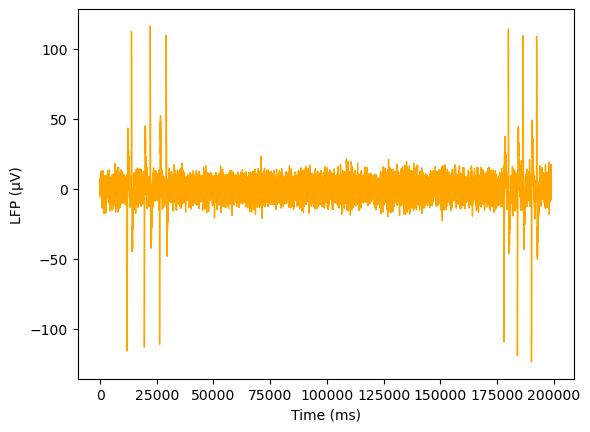

In [103]:
LFP_Stn_L_13 = data.get_data()[0]
x_time=np.arange(0,time_duration_ms,time_duration_ms/data.n_times)
df_LFP=pd.DataFrame(x_time,LFP_Stn_L_13)
plt.xlabel('Time (ms)')
plt.ylabel('LFP (µV)')
plt.plot(x_time,LFP_Stn_L_13, linewidth=1,color='orange')


In [104]:
artefact_start_time_LFP = 0
i = 0
for i in range(0,len(LFP_Stn_L_13)-1):
    if (LFP_Stn_L_13[i] <= -50):
        artefact_start_time_LFP = x_time[i]
        break
    else:
        i = i+1
print(f'the first artefact in the LFP starts at \n\t{artefact_start_time_LFP} ms')

the first artefact in the LFP starts at 
	11905.049804936953 ms


In [56]:
artefact_end_time_LFP = 0
j = 0
for j in range((int(artefact_start_time_LFP/1000*data.info["sfreq"])),len(LFP_Stn_L_13)-1):
    if (LFP_Stn_L_13[j] >= 50):
        artefact_end_time_LFP = x_time[j]
        break
    else:
        j = j+1
print(f'the first artefact in the LFP ends at \n\t{artefact_end_time_LFP} ms')

the first artefact in the LFP ends at 
	13816.135737175766 ms


In [58]:
LFP_artefact_duration = artefact_end_time_LFP - artefact_start_time_LFP
print(f'the first artefact in the LFP lasts \n\t{LFP_artefact_duration} ms')

the first artefact in the LFP lasts 
	1911.0859322388133 ms


In [105]:
second_artefact_start_time_LFP = 0
k = 0
for k in range((int(artefact_start_time_LFP/1000*data.info["sfreq"])),len(LFP_Stn_L_13)-1):
    if (LFP_Stn_L_13[k] <= -50):
        second_artefact_start_time_LFP = x_time[k]
        break
    else:
        k = k+1
print(f'the second artefact in the LFP starts at \n\t{second_artefact_start_time_LFP} ms')

the second artefact in the LFP starts at 
	19503.232037944406 ms


In [121]:
delay_between_artefacts_LFP = second_artefact_start_time_LFP - artefact_start_time_LFP
delay_between_artefacts_LFP

7598.182233007454

**Open sensor-data**

In [108]:
TMSi_data = Poly5Reader()

# Extract the samples and channel names from the Poly5Reader object
samples = TMSi_data.samples
ch_names = TMSi_data.ch_names

# Conversion to MNE raw array

toMNE = True
mne_object = TMSi_data.read_data_MNE()

# Retrieve the MNE RawArray info and sample data
info_mne = mne_object.info
samples_mne = mne_object._data
    
#mne_object.plot(start = 5, duration = 5, n_channels = 2) #(only if I want to plot in interactive viewer)

n_chan = len(mne_object.ch_names)
time_duration = (mne_object.n_times/mne_object.info['sfreq']).astype(float)
time_duration_ms=time_duration*1000

print(     
	f'The data object has:\n\t{mne_object.n_times} time samples,'      
	f'\n\tand a sample frequency of {mne_object.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{mne_object.ch_names}.')

x_time=np.arange(0,time_duration_ms,time_duration_ms/mne_object.n_times)


Reading file  C:/Users/Juliette/OneDrive - Charité - Universitätsmedizin Berlin/Recordings/TMSi files/sub-029/sub_029_18mfu_M0S0_BrStr_Rest - 20230208T101007/sub_029_18mfu_M0S0_BrStr_Rest-20230208T101007.DATA.Poly5
	 Number of samples:  795141 
	 Number of channels:  80 
	 Sample rate: 4000 Hz
Done reading data.
Creating RawArray with float64 data, n_channels=80, n_times=795141
    Range : 0 ... 795140 =      0.000 ...   198.785 secs
Ready.
The data object has:
	795141 time samples,
	and a sample frequency of 4000.0 Hz
	with a recording duration of 198.78525 seconds.
	80 channels were labeled as 
['CREF', 'UNI 01', 'UNI 02', 'UNI 03', 'UNI 04', 'UNI 05', 'UNI 06', 'UNI 07', 'UNI 08', 'UNI 09', 'UNI 10', 'UNI 11', 'UNI 12', 'UNI 13', 'UNI 14', 'UNI 15', 'UNI 16', 'UNI 17', 'UNI 18', 'UNI 19', 'UNI 20', 'UNI 21', 'UNI 22', 'UNI 23', 'UNI 24', 'UNI 25', 'UNI 26', 'UNI 27', 'UNI 28', 'UNI 29', 'UNI 30', 'UNI 31', 'UNI 32', 'UNI 33', 'UNI 34', 'UNI 35', 'UNI 36', 'UNI 37', 'UNI 38', 'UNI 39

c:\Users\Juliette\Research\Projects\Synchronization project\Code\tmsi-python-interface-main\TMSiFileFormats\file_readers\poly5reader.py:92: RuntimeWarning: Channel names are not unique, found duplicates for: {'X', 'Y', 'Z'}. Applying running numbers for duplicates.
  info = mne.create_info(ch_names=labels, sfreq=fs, ch_types=types_clean)


In [7]:
mne_object.plot(start = 5, duration = 5, n_channels = 2)

Using qt as 2D backend.


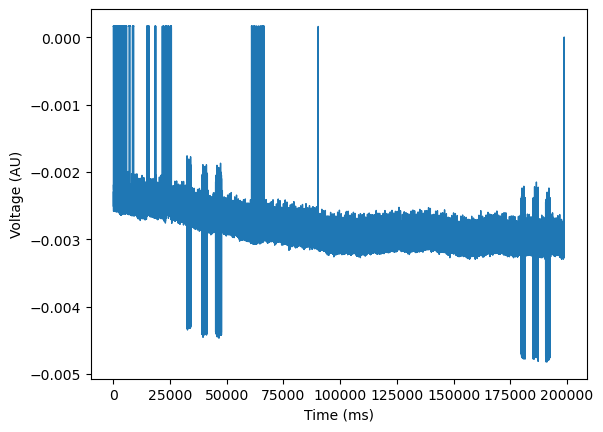

In [109]:
BIP01 = mne_object.get_data()[65]
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (AU)')
plt.plot(x_time,BIP01,linewidth=1)
plt.show()

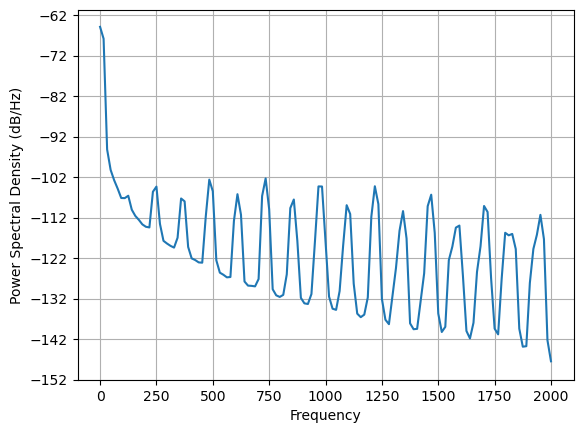

In [24]:
#mne_object.plot_psd(area_mode='range', tmax=10.0, picks=picks, average=False)

plt.psd(BIP01, Fs=4000)
plt.show()

In [110]:
#mne_object_filtered = mne_object.copy().filter(l_freq=1, h_freq=None,picks=picks)

mne_object_filtered = mne.filter.filter_data(BIP01,sfreq=4000,l_freq=1, h_freq=None)

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


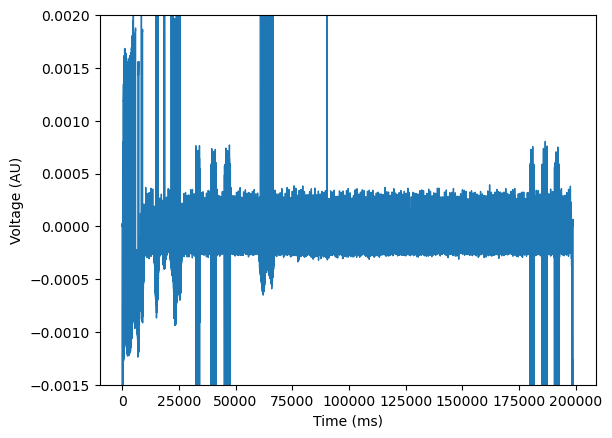

In [111]:
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (AU)')
plt.ylim(-0.0015,0.002)
plt.plot(x_time,mne_object_filtered,linewidth=1)
plt.show()

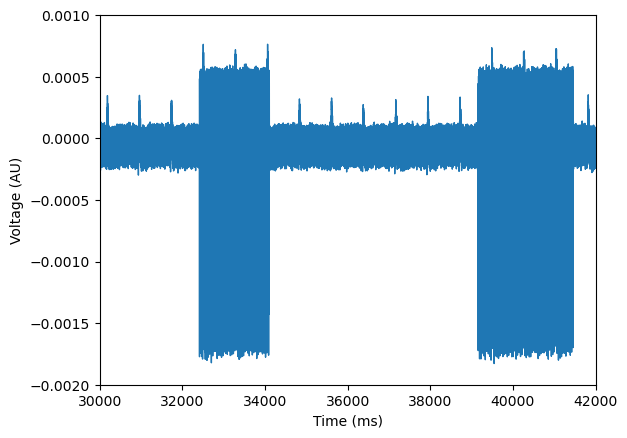

In [130]:
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (AU)')
plt.plot(x_time,mne_object_filtered,linewidth=1)
plt.xlim(30000, 42000)
plt.ylim(-0.002,0.001)
plt.show()

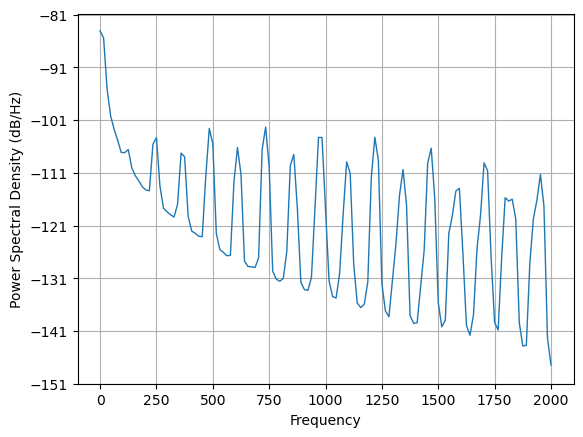

In [33]:
plt.psd(mne_object_filtered, Fs=4000, linewidth=1)
plt.show()

In [ ]:
#mne_object_filtered_h = mne.filter.filter_data(mne_object_filtered,sfreq=4000,l_freq=None, h_freq=200)

In [ ]:
#don't run
plt.psd(mne_object_filtered, Fs=4000, linewidth=1)
plt.show()

In [ ]:
#don't run
plt.plot(x_time,mne_object_filtered, linewidth=1)
plt.xlim(25000, 30000)
plt.ylim(-0.001,0.001)
plt.show()

In [ ]:
#mne_object_notched_filtered = mne.filter.notch_filter(mne_object_filtered, 4000, freqs=np.arange(50,2000,50), notch_widths=10 , trans_bandwidth=5,method='fir')

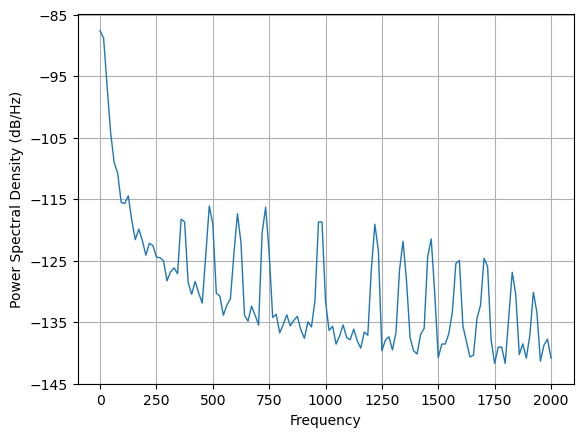

In [139]:
#don't run
plt.psd(mne_object_notched_filtered, Fs=4000, linewidth=1)
plt.show()

In [130]:
#test2 = mne_object_notched_filtered

In [ ]:
#don't run
plt.plot(x_time,test2, linewidth=1)
plt.xlim(25000, 30000)
plt.ylim(-0.0015,0.0005)
plt.show()

In [ ]:
#don't run
df_TMSi=pd.DataFrame(x_time,BIP01)
xmin=26.6*1000
xmax=26.8*1000
above_xmin = df_TMSi[df_TMSi[0] > xmin]
above_xmin
df_filtered=above_xmin[above_xmin[0] < xmax]
df_filtered


In [ ]:
#don't run
xmin=26.6*1000
xmax=26.8*1000
df_filtered=df_TMSi.loc[(df_TMSi[0] > xmin) & (df_TMSi[0] < xmax)]
df_filtered
plt.plot(df_filtered)
time_point=32000


In [ ]:
#don't run
artefact_time_TMSi = 0
i = 0
for i in range(0,len(BIP03)-1):
    if (BIP03[i] <= 0.0072):
        artefact_time_TMSi = x_time[i]
        break
    else:
        i = i+1
print(f'the artefact in the TMSi starts at \n\t{artefact_time_TMSi} ms')

In [80]:
len(mne_object_filtered)
time_point=32000
index_start = int(time_point/1000*mne_object.info['sfreq'])

In [81]:
index_start

128000

In [118]:
artefact_start_time_TMSi = 0
l = 0
for l in range(index_start,len(mne_object_filtered)-1):
    if (mne_object_filtered[l] <= -0.0005):
        artefact_start_time_TMSi = x_time[l]
        break
    else:
        l = l+1
print(f'the first artefact in the TMSi recording starts at \n\t{artefact_start_time_TMSi} ms')

the first artefact in the TMSi recording starts at 
	32416.25 ms


In [87]:
#don't run
artefact_end_time_TMSi = 0
j = 0
for j in range(int(artefact_start_time_TMSi/1000*mne_object.info['sfreq']),len(mne_object_filtered)-1):
    if (mne_object_filtered[j] >= -0.0005):
        artefact_end_time_TMSi = x_time[j]
        break
    else:
        j = j+1
print(f'the first artefact in the TMSi recording ends at \n\t{artefact_end_time_TMSi} ms')

the first artefact in the TMSi recording ends at 
	32416.0 ms


In [123]:
second_artefact_time_TMSi = 0
m = 0
for m in range(int((artefact_end_time_TMSi+LFP_artefact_duration)/1000*mne_object.info['sfreq']),len(mne_object_filtered)-1):
    if (mne_object_filtered[m] <= -0.0005):
        second_artefact_time_TMSi = x_time[m]
        break
    else:
        m = m+1
print(f'the second artefact in the TMSi recording starts at \n\t{second_artefact_time_TMSi} ms')

the second artefact in the TMSi recording starts at 
	39158.25 ms


In [127]:
delay_between_artefacts_TMSi = second_artefact_time_TMSi - artefact_start_time_TMSi
print(
        f'The delay between 2 artefacts in the LFP recording is: \t{delay_between_artefacts_LFP} ms'
        f'\n\tand the delay between 2 artefacts in the TMSi recording is: \t{delay_between_artefacts_TMSi} ms')


The delay between 2 artefacts in the LFP recording is: 	7598.182233007454 ms
	and the delay between 2 artefacts in the TMSi recording is: 	6742.0 ms


In [131]:
time_difference=delay_between_artefacts_LFP-delay_between_artefacts_TMSi
print(f'The difference in time between LFP and TMSi recordings is: {time_difference} ms')

The difference in time between LFP and TMSi recordings is: 856.1822330074538 ms


**The timing of the artefact has now been found in each recording, we can try to align**